In [66]:
import datetime as dt  
from datetime import timedelta
import matplotlib.pyplot as plt 
from matplotlib import style
from mpl_finance import candlestick_ochl
import matplotlib.dates as mdates
import pandas as pd 
import pandas_datareader as pdr 
import pandas_datareader.data as web
from pandas.plotting import register_matplotlib_converters
import numpy as np
from collections import Counter
import os
import bs4 as bs 
import pickle
import requests 
from sklearn import svm, neighbors
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.stattools as ts 
style.use('ggplot')
register_matplotlib_converters()

In [2]:
# these are the companies we are interested in, so we will hard code the tickers in this array 
tickers = ['AAPL','AXP','NKE','CVX','JNJ','F','ALK']


In [5]:
# variables we will need
# datetime(year, month, day) 
sars = 'sars'
start_sars = dt.datetime(2002,10,1)
end_sars = dt.datetime(2004,1,1)

swine = 'swine'
start_swine = dt.datetime(2009,4,15)
end_swine = dt.datetime(2010,8,11)

ebola = 'ebola'
start_ebola = dt.datetime(2013,12,1)
end_ebola = dt.datetime(2016,1,14)

corona = 'corona'
start_corona = dt.datetime(2019,11,17)
end_corona = dt.datetime(2020,4,24)

pandemics = [sars,swine,ebola,corona]

In [6]:
######### get the data for each time period of the corresponding pandemic 
def get_data_from_yahoo_pandemic(pandemic,start,end):
    # with open('sp500tickers.pickle','rb') as f:
    #         tickers = pickle.load(f)
    if not os.path.exists('stock_dfs_{}'.format(pandemic)):
        os.makedirs('stock_dfs_{}'.format(pandemic))

    # tickers = ['AAPL','AXP','NKE','CVX','JNJ','F','ALK']
    # start = dt.datetime(2002,10,1)
    # end = dt.datetime(2003,9,1)


    # to test use tickers[:10] so you don't have to wiat for all 500
    for ticker in tickers:
        print(ticker)
        if not os.path.exists('stock_dfs_{}/{}.csv'.format(pandemic,ticker)):
            try:
                df = web.DataReader(ticker,'yahoo',start,end)
                df.to_csv('stock_dfs_{}/{}.csv'.format(pandemic,ticker))
            except KeyError:
                pass
        else:
            print('Already have {}'.format(ticker))

In [7]:
# sars
get_data_from_yahoo_pandemic(sars,start_sars,end_sars)

# swine
get_data_from_yahoo_pandemic(swine,start_swine,end_swine)

# ebola
get_data_from_yahoo_pandemic(ebola,start_ebola,end_ebola)

# corona
get_data_from_yahoo_pandemic(corona,start_corona,end_corona)

AAPL
AXP
NKE
CVX
JNJ
F
ALK
AAPL
AXP
NKE
CVX
JNJ
F
ALK
AAPL
AXP
NKE
CVX
JNJ
F
ALK
AAPL
AXP
NKE
CVX
JNJ
F
ALK


In [18]:
########### combine each dataset into one csv
def compile_data_pandemic(pandemic):
    # with open("sp500tickers.pickle","rb") as f:
    #     tickers = pickle.load(f)

    main_df = pd.DataFrame()
    # tickers = ['AAPL','AXP','NKE','CVX','JNJ','F','ALK']
    for count,ticker in enumerate(tickers):
        try:
            df = pd.read_csv('stock_dfs_{}/{}.csv'.format(pandemic,ticker))
            df.set_index('Date',inplace=True)

            df.rename(columns = { 'Adj Close': ticker}, inplace=True)
            df.drop(['Open','High','Low','Close','Volume'],1,inplace=True)
            if main_df.empty:
                main_df = df
            else:
                main_df = main_df.join(df, how = 'outer')
            
            if count % 10 == 0:
                # print(count)
                pass
        except FileNotFoundError as e:
            print('no file')
            continue
    main_df.to_csv('stock_dfs_{}/{}.csv'.format(pandemic,pandemic))
    return main_df

In [19]:
# sars 
sars_df = compile_data_pandemic(sars)
# swine
swine_df = compile_data_pandemic(swine)
# ebola
ebola_df = compile_data_pandemic(ebola)
# corona
corona_df = compile_data_pandemic(corona)

In [20]:
############# process data for labels ... 

def process_data_for_labels(pandemic,ticker):
    # how many days 
    days = 7 
    df = pd.read_csv('stock_dfs_{}/{}.csv'.format(pandemic,pandemic), index_col=0)
    # df = pd.read_csv('sars_data.csv', index_col=0)

    tickers = df.columns.values.tolist()
    df.fillna(0,inplace=True)

    for i in range(1, days+1):
        df['{}_{}d'.format(ticker,i)] = (df[ticker].shift(-i) - df[ticker]) / df[ticker]
    df.fillna(0,inplace=True)
    return tickers,df

In [21]:
############# ml target function 
def buy_sell_hold(*args):
    cols = [c for c in args]
    requirement = .02
    for col in cols:
        if col > requirement:
            return 1
        if col < -requirement:
            return -1

    return 0

In [22]:
def extract_feature_sets(pandemic,ticker):
    tickers, df = process_data_for_labels(pandemic,ticker)
    hm_days=7

    df['{}_target'.format(ticker)] = list(map( buy_sell_hold, df['{}_1d'.format(ticker)],
        df['{}_2d'.format(ticker)],
        df['{}_3d'.format(ticker)],
        df['{}_4d'.format(ticker)],
        df['{}_5d'.format(ticker)],
        df['{}_6d'.format(ticker)],
        df['{}_7d'.format(ticker)]
        ))
    #list(map(buy_sell_hold, *[df['{}_{}d'.format(ticker, i)]for i in range(1, hm_days+1)]))

    vals = df['{}_target'.format(ticker)].values.tolist()
    str_vals = [str(i) for i in vals]
    print('Data spread: ',Counter(str_vals))
    df.fillna(0,inplace=True)

    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)

    df_vals = df[[ticker for ticker in tickers ]].pct_change()
    df_vals = df_vals.replace([np.inf, -np.inf],0)
    df_vals.fillna(0, inplace=True)

    X=df_vals.values
    y=df['{}_target'.format(ticker)].values

    return X,y

In [23]:
########### actual ml 
def do_ml(pandemic,ticker):
    X,y=extract_feature_sets(pandemic,ticker)

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25,random_state=42)


    # K nearest neighbors
    clf = neighbors.KNeighborsClassifier()
    # voting classifies
    clf = VotingClassifier([
        ('lsvc', svm.LinearSVC()),
        ('knn', neighbors.KNeighborsClassifier()),
        ('rfor', RandomForestClassifier())
    ])



    clf.fit(X_train,y_train) 
    confidence = clf.score(X_test,y_test)
    print('Accuracy:',confidence)
    predictions = clf.predict(X_test)
    print('Predicted spread:',Counter(predictions))

    return confidence

In [24]:
for ticker in tickers:
    print(ticker)
    for pandemic in pandemics:
        print(pandemic)
        do_ml(pandemic,ticker)
        print('\n')
    print('\n\n')

AAPL
sars
Data spread:  Counter({'1': 118, '-1': 105, '0': 8})
Accuracy: 0.39655172413793105
Predicted spread: Counter({1: 39, -1: 19})


swine
Data spread:  Counter({'1': 183, '-1': 122, '0': 30})
Accuracy: 0.42857142857142855
Predicted spread: Counter({1: 67, -1: 17})


ebola
Data spread:  Counter({'1': 221, '-1': 211, '0': 102})
Accuracy: 0.3880597014925373
Predicted spread: Counter({1: 71, -1: 62, 0: 1})


corona
Data spread:  Counter({'1': 62, '-1': 39, '0': 8})
Accuracy: 0.5714285714285714
Predicted spread: Counter({1: 24, -1: 4})





AXP
sars
Data spread:  Counter({'1': 111, '-1': 102, '0': 18})
Accuracy: 0.5344827586206896
Predicted spread: Counter({-1: 37, 1: 21})


swine
Data spread:  Counter({'1': 191, '-1': 122, '0': 22})
Accuracy: 0.5595238095238095
Predicted spread: Counter({1: 72, -1: 12})


ebola
Data spread:  Counter({'-1': 205, '0': 173, '1': 156})
Accuracy: 0.3358208955223881
Predicted spread: Counter({-1: 109, 0: 20, 1: 5})


corona
Data spread:  Counter({'1': 46, 

## moving average

In [16]:
%cd '/Users/austinwilson/Desktop/CSUS/177/final project/final solution'

/Users/austinwilson/Desktop/CSUS/177/final project/final solution


In [33]:
aapl = pd.read_csv('stock_dfs/AAPL.csv',parse_dates=True,index_col=0)
axp = pd.read_csv('stock_dfs/AXP.csv',parse_dates=True,index_col=0)
nke = pd.read_csv('stock_dfs/NKE.csv',parse_dates=True,index_col=0)
cvx = pd.read_csv('stock_dfs/CVX.csv',parse_dates=True,index_col=0)
jnj = pd.read_csv('stock_dfs/JNJ.csv',parse_dates=True,index_col=0)
f = pd.read_csv('stock_dfs/F.csv',parse_dates=True,index_col=0)
alk = pd.read_csv('stock_dfs/ALK.csv',parse_dates=True,index_col=0)

# when shrot term MA crosses above long term MA its a buy signal 
# when sort term MA crosses below long term MA sell signal 
# https://www.investopedia.com/articles/active-trading/052014/how-use-moving-average-buy-stocks.asp
# tickers = ['AAPL','AXP','NKE','CVX','JNJ','F','ALK']

Text(0.5, 1.0, 'apple')

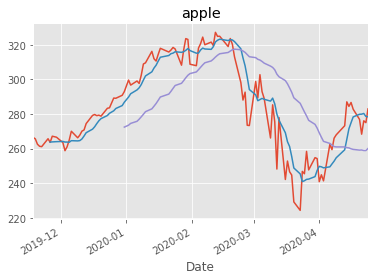

In [26]:
# apple moving average graph
aapl['Adj Close']['2019-11-17':].plot()
aapl['Adj Close']['2019-11-17':].rolling(7).mean().plot()
aapl['Adj Close']['2019-11-17':].rolling(30).mean().plot()
plt.title('apple')

Text(0.5, 1.0, 'American Express')

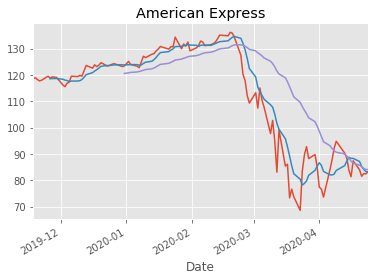

In [27]:
# american express
axp['Adj Close']['2019-11-17':].plot()
axp['Adj Close']['2019-11-17':].rolling(7).mean().plot()
axp['Adj Close']['2019-11-17':].rolling(30).mean().plot()
plt.title('American Express')

Text(0.5, 1.0, 'Nike')

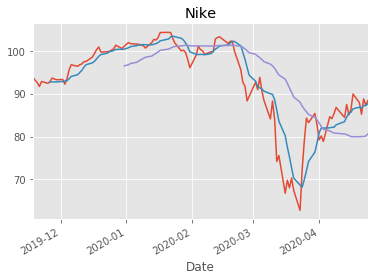

In [28]:
# Nike
nke['Adj Close']['2019-11-17':].plot()
nke['Adj Close']['2019-11-17':].rolling(7).mean().plot()
nke['Adj Close']['2019-11-17':].rolling(30).mean().plot()
plt.title('Nike')

Text(0.5, 1.0, 'Chevron')

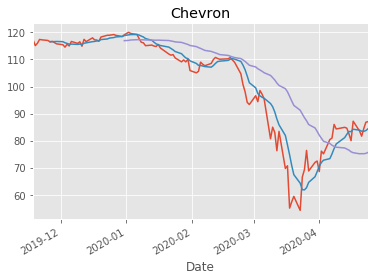

In [29]:
# Chevron
cvx['Adj Close']['2019-11-17':].plot()
cvx['Adj Close']['2019-11-17':].rolling(7).mean().plot()
cvx['Adj Close']['2019-11-17':].rolling(30).mean().plot()
plt.title('Chevron')

Text(0.5, 1.0, 'Johnson&Johnson')

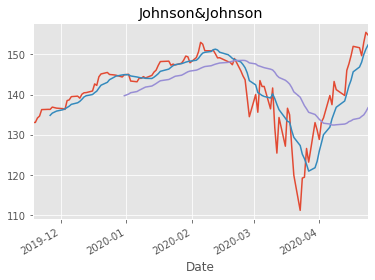

In [30]:
# JNJ
jnj['Adj Close']['2019-11-17':].plot()
jnj['Adj Close']['2019-11-17':].rolling(7).mean().plot()
jnj['Adj Close']['2019-11-17':].rolling(30).mean().plot()
plt.title('Johnson&Johnson')

Text(0.5, 1.0, 'Ford')

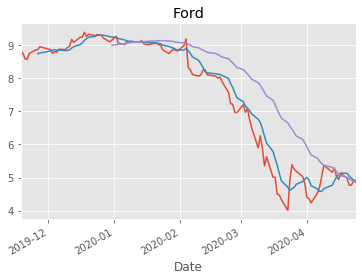

In [31]:
# JNJ
f['Adj Close']['2019-11-17':].plot()
f['Adj Close']['2019-11-17':].rolling(7).mean().plot()
f['Adj Close']['2019-11-17':].rolling(30).mean().plot()
plt.title('Ford')

Text(0.5, 1.0, 'Alaskan Airlines')

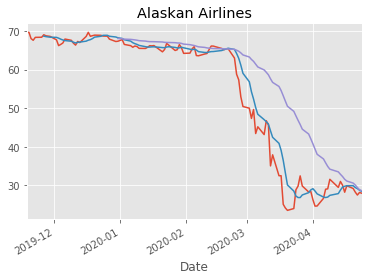

In [34]:
# JNJ
alk['Adj Close']['2019-11-17':].plot()
alk['Adj Close']['2019-11-17':].rolling(7).mean().plot()
alk['Adj Close']['2019-11-17':].rolling(30).mean().plot()
plt.title('Alaskan Airlines')

<BarContainer object of 40 artists>

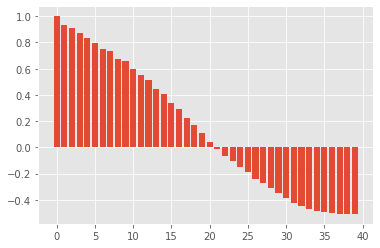

In [44]:
# autocorrelation function = acf 
acf_vals = acf(aapl['Adj Close']['2019-11-17':])
num_lags = 40
plt.bar(range(num_lags),acf_vals[:num_lags])

<BarContainer object of 20 artists>

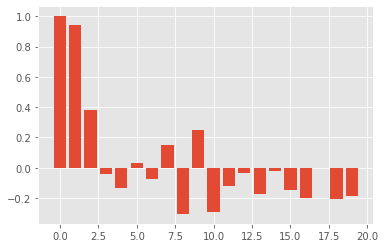

In [42]:
pacf_vals = pacf(aapl['Adj Close']['2019-11-17':])
num_lags = 20
plt.bar(range(num_lags), pacf_vals[:num_lags])

In [45]:
# train test split 
train_end = dt.datetime(2019,12,20)
test_end = dt.datetime(2020,1,1)
train_data = aapl['Adj Close'][:train_end]
test_data = aapl['Adj Close'][train_end + timedelta(days=1):test_end]

In [48]:
# model
model = ARIMA(train_data, order = (0,0,2))

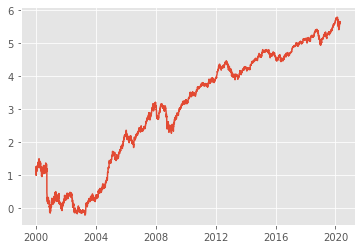

In [64]:
log_aapl_price = np.log(aapl['Adj Close'])
# log_jnj_price = np.log(jnj['Adj Close'])
plt.plot(log_aapl_price)
# plt.plot(log_jnj_price)

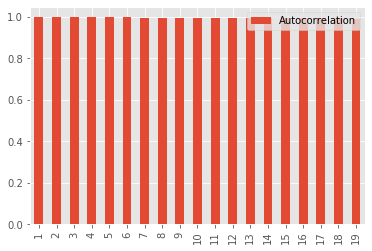

In [62]:
acf_1 = acf(log_aapl_price)[1:20]
test_df = pd.DataFrame([acf_1]).T
test_df.columns = ['Autocorrelation']
test_df.index += 1 
test_df.plot(kind='bar')
plt.show()

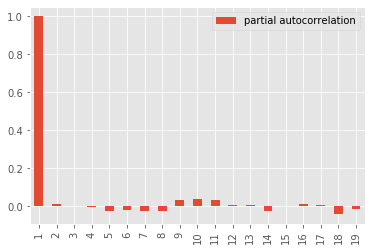

In [63]:
pacf_1 = pacf(log_aapl_price)[1:20]
test_df = pd.DataFrame([pacf_1]).T
test_df.columns = ['partial autocorrelation']
test_df.index += 1 
test_df.plot(kind='bar')
plt.show()

In [67]:
result = ts.adfuller(log_aapl_price,1)
result
lnprice_diff = log_aapl_price - log_aapl_price.shift()
diff = lnprice_diff.dropna()
acf_1_diff = acf(diff)[1:20]
test_df = pd.DataFrame([acf_1_diff]).T
test_df.columns = ['First difference autocorrelation']


(0.029027263189168158,
 0.9608677936957113,
 1,
 5108,
 {'1%': -3.431630851460861,
  '5%': -2.8621060004758108,
  '10%': -2.5670712822869404},
 -22541.990683683915)